# Feature Importance in XGBoost With SHAP

The objective of this notebook is to take a deeper dive into the XGBoost model.
Given that XGBoost does not provide positive/negative weights, contraty to logistic regression, it is necessary to better understand what is going on under the hood.
Should we need to make recommendations for businesses in order to stay open, we ought to know what to recommend and in what measure.


The steps shown below are based on the article [Interpretable Machine Learning with XGBoost by Scott Lundberg](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils, plot_help, pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, \
                            roc_curve, roc_auc_score, precision_recall_curve
from joblib import dump, load

import xgboost as xgb
import shap


%matplotlib inline

## Load trained XGB + Dataframe

In [2]:
#change read limit to -1 to load entire dataframe
df_bus_dens = utils.chunk_loader('data/cleaned/business_merge_density_added.csv', read_limit=-1)

#original dataframe
df = utils.chunk_loader('data/business.json', read_limit=-1)

df_bus_dens = utils.make_num_df(df_bus_dens)

#shap format input
X, y = df_bus_dens.iloc[:,:-1].copy(), df_bus_dens.iloc[:,-1].copy()

X_train, X_test, y_train, y_test = utils.train_test_scale (df_bus_dens, 
                                                           'is_open', 
                                                           random_state=None)

#apply oversampling
X_train, y_train = utils.oversample(X_train, y_train)


In [3]:
#load the model
xgb_over = utils.pickle_load('models/xgb_over.pickle')

In [4]:
#remake predictions
y_pred = xgb_over.predict(X_test)

### Feature Importance: Weight

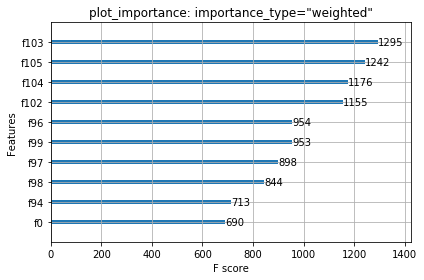

In [5]:
#”weight” is the number of times a feature appears in a tree
xgb.plot_importance(xgb_over, 
                    importance_type='weight',
                    max_num_features=10, 
                    title='plot_importance: importance_type="weighted"')
plt.tight_layout()
plt.savefig("plots/xgb_plot_imp_weighted.png")
plt.show()


In [6]:
#top 5 by weight
print(df_bus_dens.columns[[103, 104, 102, 105, 96]])

Index(['review_density', 'stars_density', 'density', 'price_density',
       'stars_change'],
      dtype='object')


### Feature Importance: Gain

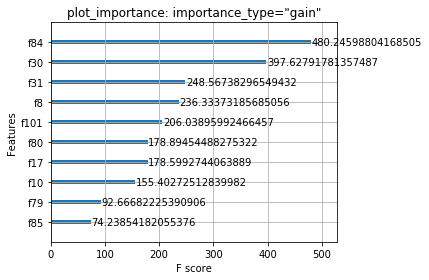

In [7]:
#”gain” is the average gain of splits which use the feature

xgb.plot_importance(xgb_over, 
                    importance_type='gain',
                    max_num_features=10, 
                    title='plot_importance: importance_type="gain"')
plt.tight_layout()
plt.savefig("plots/xgb_plot_imp_gain.png")
plt.show()


In [8]:
#top 5 by gain
print(df_bus_dens.columns[[30, 84, 8, 31, 17]])

Index(['lunch', 'Restaurants', 'RestaurantsPriceRange2', 'dinner',
       'AcceptsInsurance'],
      dtype='object')


### Feature Importance: Cover

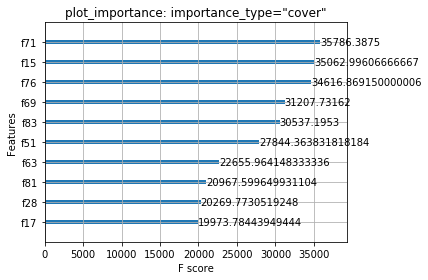

In [9]:
#is the average coverage of splits which use the feature 
#where coverage is defined as the number of samples affected by the split

xgb.plot_importance(xgb_over, 
                    importance_type='cover',
                    max_num_features=10, 
                    title='plot_importance: importance_type="cover"')
plt.tight_layout()
plt.savefig("plots/xgb_plot_imp_cover.png")
plt.show()


In [10]:
#top 5 by cover
print(df_bus_dens.columns[[76, 69, 83, 65, 46]])

Index(['vegetarian', 'asian', 'AgesAllowed', 'africanamerican', 'upscale'], dtype='object')


## Feature Attribution: SHapley Additive exPlanations

In [11]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(xgb_over)

In [12]:
shap_values = explainer.shap_values(X)

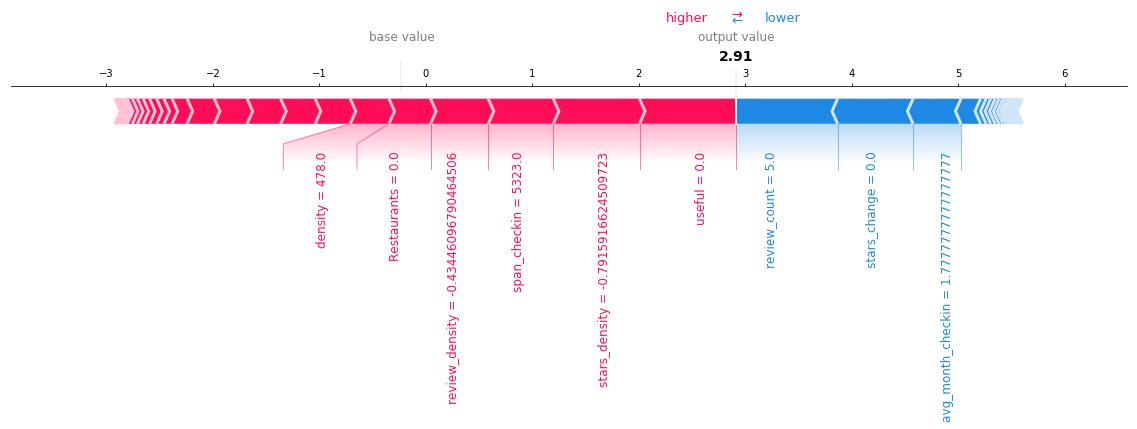

In [13]:
# load JS visualization code to notebook
shap.initjs()

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(base_value = explainer.expected_value, 
                shap_values = shap_values[0,:], 
                features = X.iloc[0,:], 
                matplotlib=True,
               text_rotation=90)

In [14]:
#quick representation check
y.iloc[:1000].mean()

0.801

In [15]:
### !WARNING! Specifcy small amount of samples to avoid crash !WARNING!

# visualize the training set predictions
shap.force_plot(explainer.expected_value, 
                shap_values[:1000,:], 
                X.iloc[:1000,:])

### Take the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.


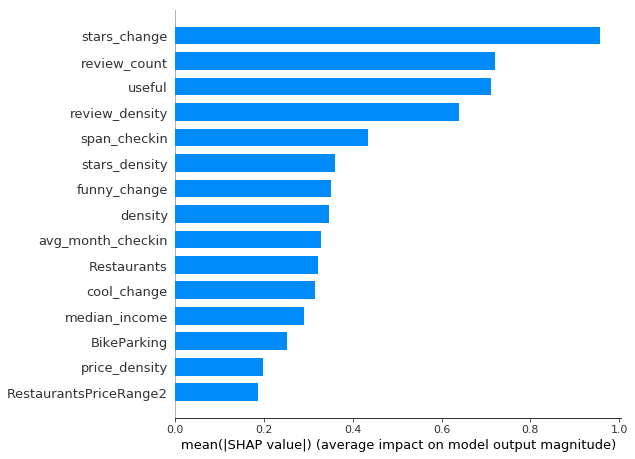

In [16]:
shap.summary_plot(shap_values, 
                  X, 
                  plot_type="bar", 
                  #title='SHAP Values Average Magnitude', 
                  max_display=15)
plt.show()

### SHAP Summary Plot

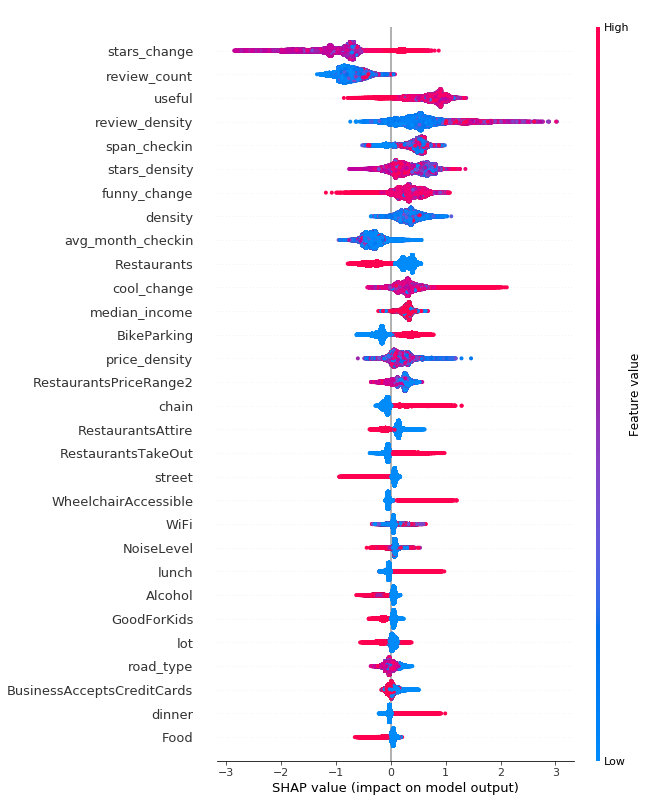

In [17]:
shap.summary_plot(shap_values, 
                  X, 
                  max_display=30)

### SHAP Dependence Plots

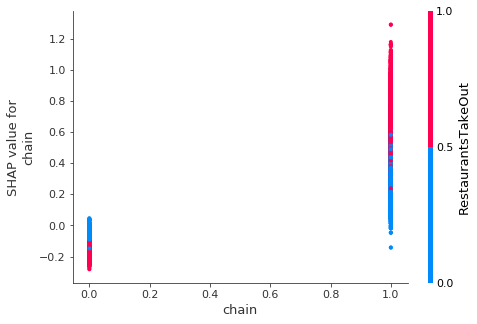

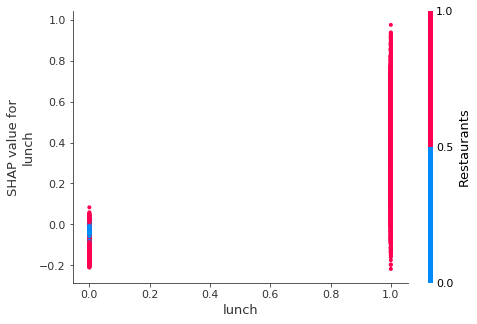

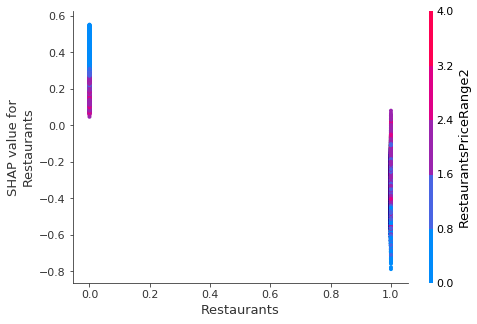

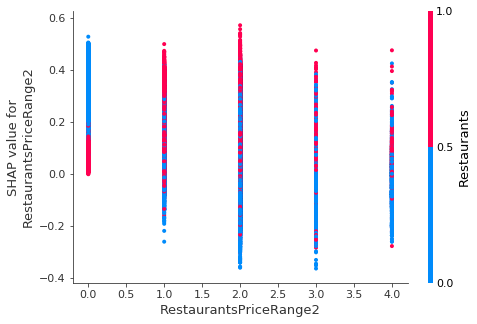

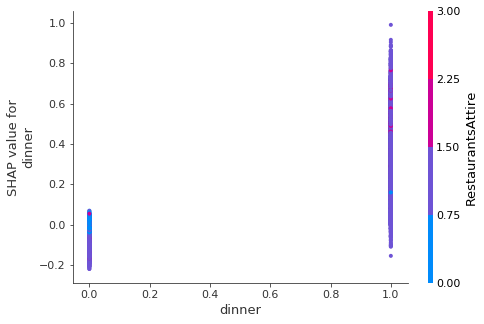

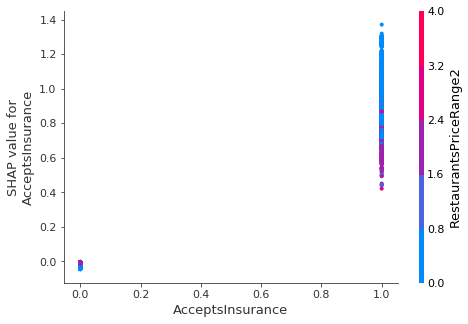

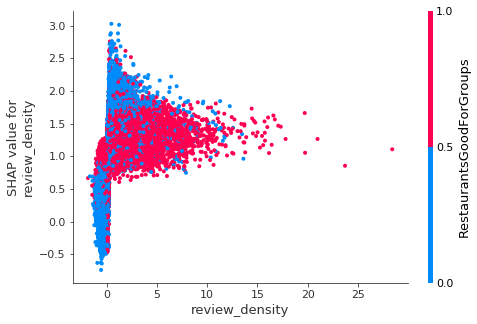

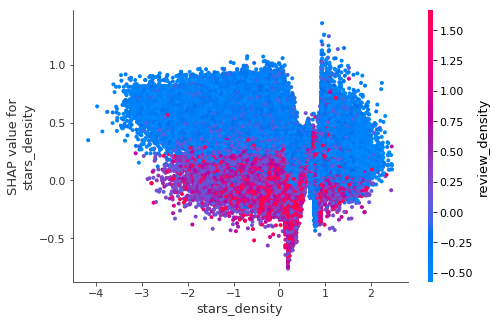

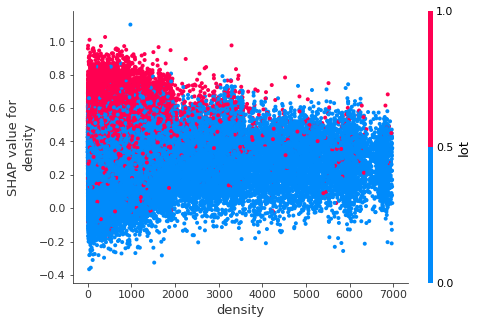

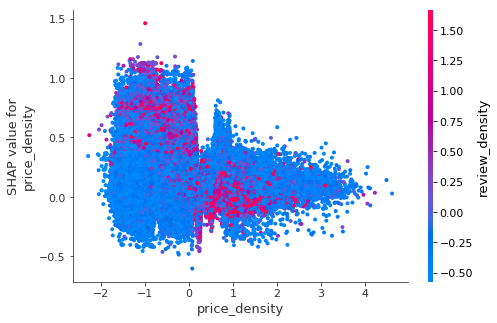

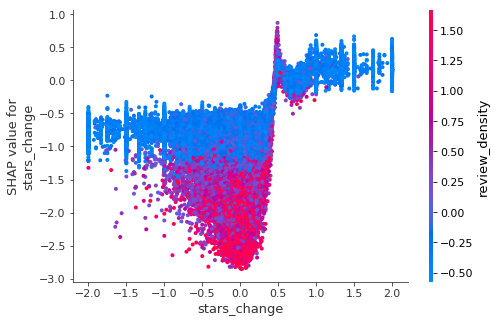

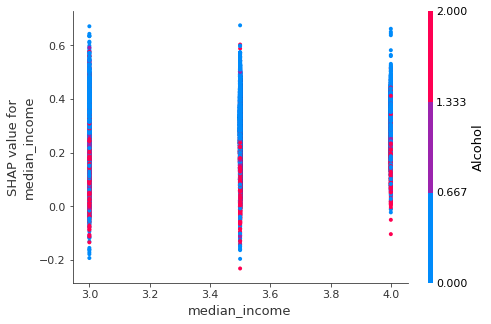

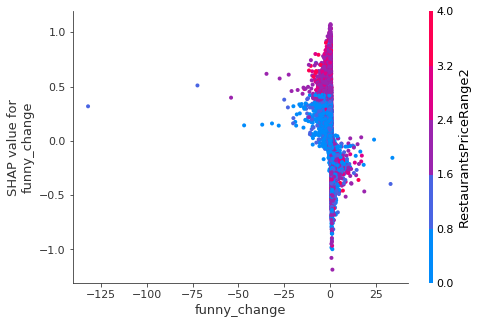

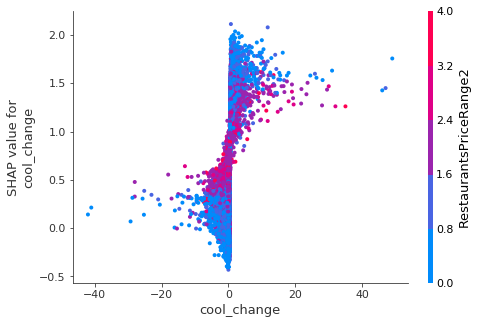

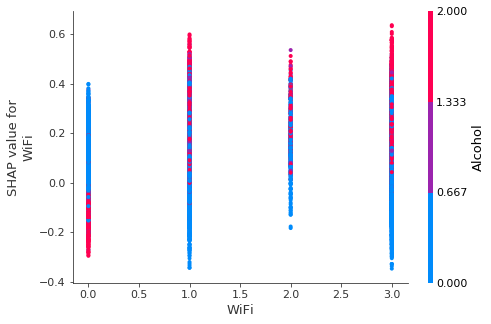

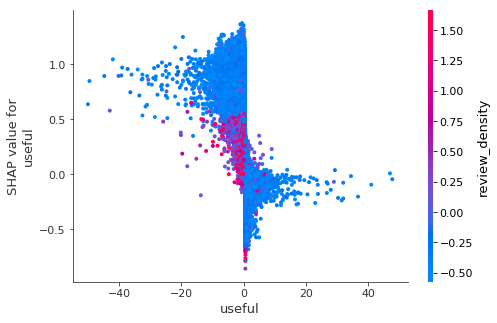

In [18]:
# pick the more relevant columns instead of drawing 100+ plots

for name in ['chain', 'lunch', 'Restaurants', 'RestaurantsPriceRange2', 'dinner',
             'AcceptsInsurance', 'review_density', 'stars_density', 
             'density', 'price_density', 'stars_change', 'median_income', 
             'funny_change', 'cool_change', 'WiFi', 'useful']:
    shap.dependence_plot(name, 
                         shap_values, 
                         X, 
                         display_features=X)

### Simple supervised clustering

In [19]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [20]:
shap_pca50 = PCA(n_components=12).fit_transform(shap_values[:1000,:])
shap_embedded = TSNE(n_components=2, perplexity=50).fit_transform(shap_values[:1000,:])

In [21]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
cdict1 = {
    'red': ((0.0, 0.11764705882352941, 0.11764705882352941),
            (1.0, 0.9607843137254902, 0.9607843137254902)),

    'green': ((0.0, 0.5333333333333333, 0.5333333333333333),
              (1.0, 0.15294117647058825, 0.15294117647058825)),

    'blue': ((0.0, 0.8980392156862745, 0.8980392156862745),
             (1.0, 0.3411764705882353, 0.3411764705882353)),

    'alpha': ((0.0, 1, 1),
              (0.5, 1, 1),
              (1.0, 1, 1))
}  # #1E88E5 -> #ff0052
red_blue_solid = LinearSegmentedColormap('RedBlue', cdict1)

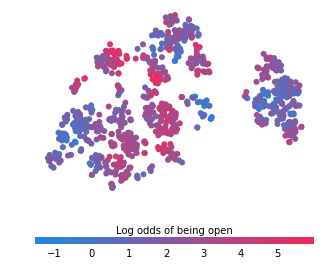

In [22]:
f = plt.figure(figsize=(5,5))
plt.scatter(shap_embedded[:,0],
           shap_embedded[:,1],
           c=shap_values[:1000,:].sum(1).astype(np.float64),
           linewidth=0, alpha=1., cmap=red_blue_solid)
cb = plt.colorbar(label="Log odds of being open", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
plt.gca().axis("off")
plt.show()

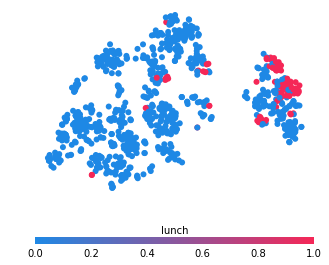

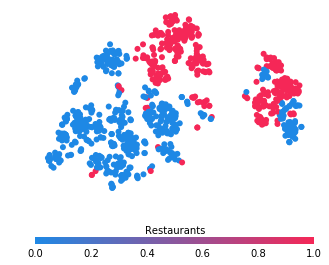

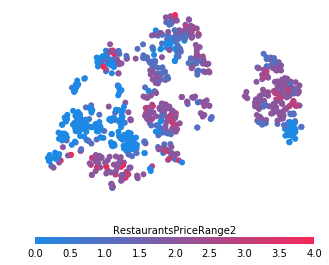

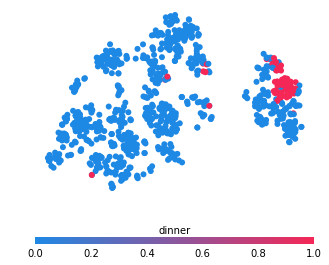

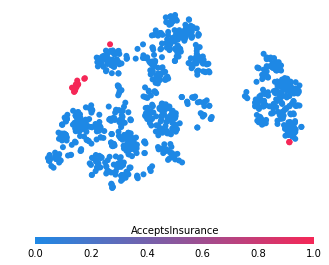

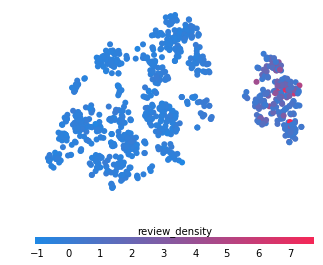

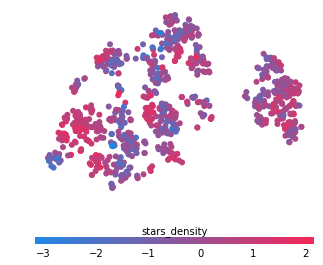

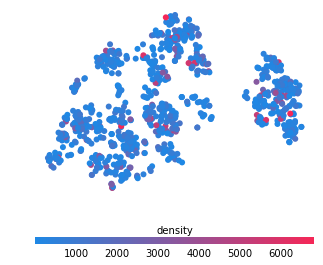

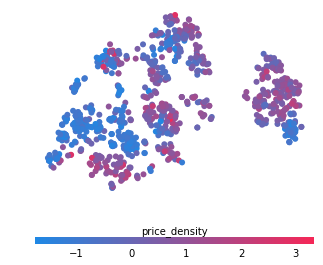

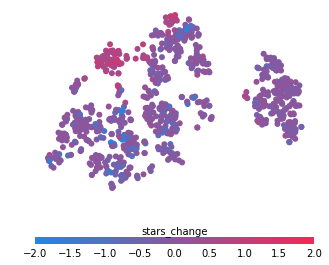

In [23]:
for feature in ['lunch', 'Restaurants', 'RestaurantsPriceRange2', 'dinner',
             'AcceptsInsurance', 'review_density', 'stars_density', 
             'density', 'price_density', 'stars_change']:
    f = plt.figure(figsize=(5,5))
    plt.scatter(shap_embedded[:,0],
               shap_embedded[:,1],
               c=X[feature].values[:1000].astype(np.float64),
               linewidth=0, alpha=1., cmap=red_blue_solid)
    cb = plt.colorbar(label=feature, aspect=40, orientation="horizontal")
    cb.set_alpha(1)
    cb.draw_all()
    cb.outline.set_linewidth(0)
    cb.ax.tick_params('x', length=0)
    cb.ax.xaxis.set_label_position('top')
    plt.gca().axis("off")
    plt.show()

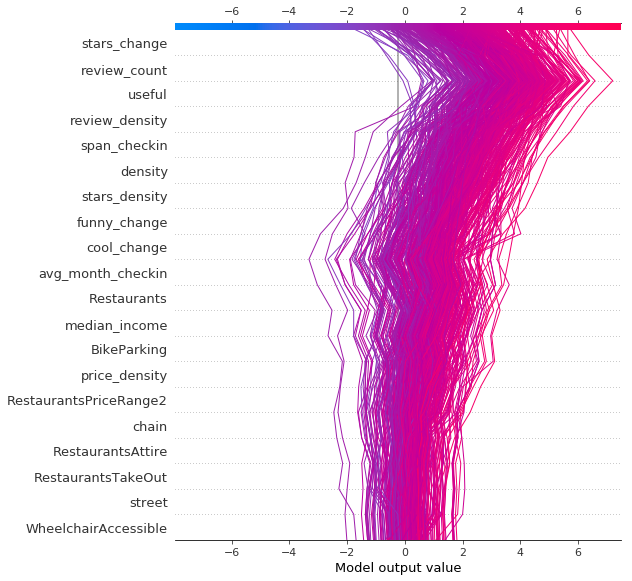

In [24]:
select = range(20)
features = X.iloc[select]
features_display = X.loc[features.index]

shap.decision_plot(explainer.expected_value,
                   shap_values[:500], 
                   features_display.values[:500],
                  feature_names = X.columns.values.tolist())


## Correlation Coefficient

In [50]:
#take the mean absolute value of the SHAP values for each feature
shap_val_mean= np.abs(shap_values).mean(0)

#find the arguments in descending order
shap_topk_idx = np.argsort(shap_val_mean)[::-1]

#select top k columns by feature importance
topk= 10
shap_top_col = df_bus_dens.columns[shap_topk_idx[:topk]]

#select columns
df_shap_topk = df_bus_dens[shap_top_col].copy()

#add target variable
df_shap_topk['is_open'] = df_bus_dens['is_open']

df_shap_topk.head()

stars_change  review_count    useful  review_density  span_checkin  \
0      0.000000             5  0.000000       -0.434461          5323   
1     -0.075163           128 -0.156863        2.886616         15143   
2      0.055000           170 -0.215000        3.080444         58518   
3      0.000000             3 -0.500000       -0.544127          8464   
4      0.000000             3  0.000000       -0.521945          2971   

   stars_density  funny_change  density  avg_month_checkin  Restaurants  \
0      -0.791592       0.00000      478           1.777778            0   
1      -0.815147      -0.04902      325          36.083333            1   
2       0.645325      -0.19000      460          57.083333            1   
3       1.655468       0.00000      210           1.222222            0   
4      -0.928338       0.00000      234           1.000000            0   

   is_open  
0        0  
1        1  
2        1  
3        1  
4        1

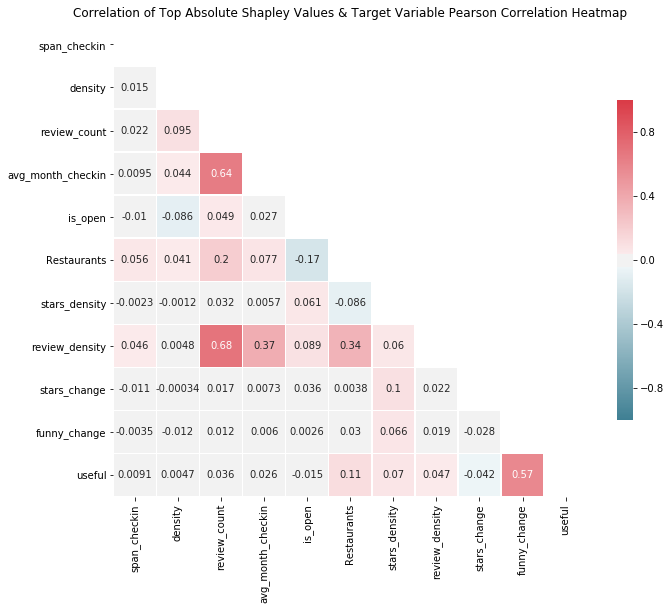

In [52]:
plot_help.df_binary_corr_plot(df_shap_topk, 
                              title='Correlation of Top Absolute Shapley Values & Target Variable', 
                              savepath='plots/shap_corr_matrix.png',
                             fig_size=(10,10))

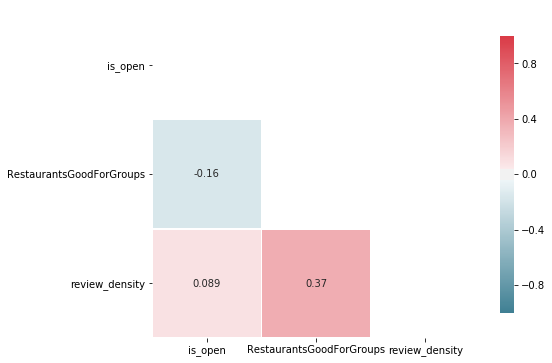

In [58]:
plot_help.df_binary_corr_plot(df_bus_dens[['RestaurantsGoodForGroups', 'review_density', 'is_open']], 
                             fig_size=(8,8))